In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats             import hypergeom
import seaborn as sns
from matplotlib_venn         import venn2, venn3


def safe_div(x,y):
    if y == 0:
        return np.array([0])
    return x / y


def calculate_enrichment(hit_list, top_genes, full_gene_list):
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( (x/N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p


# Load OCR data from Markenscoff-Papadimitriou et al https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7415678/
# download from supplmental materials
# coordinates and metadata of all predicted regulatory elements (n=19,151)
pRE_annotations = pd.read_csv('pRE_annotations.csv')

# OCRs specific to upper or lower layer neurons 
OCR_upper_lower = pd.read_csv('OCRs_upper_lower.csv')

# upper layer OCRs annotated with TF motifs for immature/mature neurons
tfs = pd.read_csv('OCRs_upper_TFs.csv')

### Are ZRT<sub>neo</sub> genes located near to open chromatin regions in the fetal brain?

In [2]:
# load ZRT gene identities
zrt_gene_identities = pd.read_csv('RESULTS/ZRT-gene-identities.csv')

# get gene lists for:
# ZRT genes
zrt_genes = zrt_gene_identities['gene'].values
# ZRT_scaling genes
zrt_scaling = zrt_gene_identities[zrt_gene_identities['is_scaling']==1]['gene'].values
# ZRT neo genes
zrt_neo = zrt_gene_identities[zrt_gene_identities['is_scaling_reduced']==1]['gene'].values
# non-scaling ZRT genes
zrt_non_scaling = zrt_gene_identities[(zrt_gene_identities['is_scaling']==0) & (zrt_gene_identities['is_scaling_reduced']==0)]['gene'].values

# all microarray genes
all_microarray_genes = np.loadtxt('RESULTS/all-microarray-genes.txt', dtype='str')

# non ZRT genes
non_zrt_genes = [i for i in all_microarray_genes if i not in zrt_gene_identities['gene'].values]

In [3]:


# remove date names
pRE_annotations = pRE_annotations[(~pRE_annotations['closest_upstream_pc_gene'].str.contains('Mar')) & (~pRE_annotations['closest_downstream_pc_gene'].str.contains('Mar')) ]
pRE_annotations = pRE_annotations[(~pRE_annotations['closest_upstream_pc_gene'].str.contains('Sep')) & (~pRE_annotations['closest_downstream_pc_gene'].str.contains('Sep')) ]
pRE_annotations = pRE_annotations[(~pRE_annotations['closest_upstream_pc_gene'].str.contains('Dec')) & (~pRE_annotations['closest_downstream_pc_gene'].str.contains('Dec')) ]


# account for +1 mismatch in the coordinates between OCR_upper_lower and tfs: 
# e.g.: chr1:90064273-90065131 -> chr1:9006427*2*-90065131

coord_list = []
for i in tfs['coordiantes UL pRE (hg19)']:
    i_str = i.split('-')[0][:-1]
    upper_coord = OCR_upper_lower[OCR_upper_lower['coordinates (hg19)'].str.contains(i_str)]['coordinates (hg19)']
    if len(upper_coord)>0:
        coord_list.append([i, upper_coord.values[0]])
    else:
        coord_list.append([i, np.nan])
        
coord_dict = dict(zip(pd.DataFrame(coord_list)[1], pd.DataFrame(coord_list)[0]))
OCR_upper_lower.loc[:,'tfs_coord'] = OCR_upper_lower.loc[:,'coordinates (hg19)'].map(coord_dict)


# annotate OCRs with nearest gene
us_gene = dict(zip(pRE_annotations['pRE coordinates (hg19)'], pRE_annotations['closest_upstream_pc_gene']))
ds_gene = dict(zip(pRE_annotations['pRE coordinates (hg19)'], pRE_annotations['closest_downstream_pc_gene']))
OCR_upper_lower.loc[:,'downstream'] = OCR_upper_lower.loc[:,'coordinates (hg19)'].map(ds_gene)
OCR_upper_lower.loc[:,'upstream'] = OCR_upper_lower.loc[:,'coordinates (hg19)'].map(us_gene)
# drop any that are missing nearby genes
OCR_upper_lower = OCR_upper_lower[~pd.isna(OCR_upper_lower['downstream']) | ~pd.isna(OCR_upper_lower['upstream'])]

In [4]:
# all genes located up or downstream of pREs in the fetal brain
nearby_genes = np.unique(pRE_annotations[['closest_upstream_pc_gene', 'closest_downstream_pc_gene']].values.reshape(-1))
upstream_genes = np.unique(pRE_annotations[['closest_upstream_pc_gene']].values.reshape(-1))
downstream_genes = np.unique(pRE_annotations[['closest_downstream_pc_gene']].values.reshape(-1))

print('{:} genes located near to (up or downstream of) pREs in the fetal brain'.format(len(nearby_genes)))
print('{:} genes located upstream of pREs'.format(len(upstream_genes)))
print('{:} genes located downstream of pREs'.format(len(downstream_genes)))
print('')

# calculate enrichment of pRE genes in each set of ZRT genes
enrichment_data = []
for genelist, genelistname in zip([non_zrt_genes, zrt_genes, zrt_scaling, zrt_neo], ['nonZRT', 'ZRT', 'ZRT_scaling', 'ZRT_neo']):
    e,p = calculate_enrichment(nearby_genes, genelist, all_microarray_genes)
    # percent overlap
    overlap = len((set(nearby_genes) & set(genelist))) / len(genelist)
    enrichment_data.append([genelistname] + [e[0],p[0], overlap])

enrichment_data = pd.DataFrame(enrichment_data)
enrichment_data.columns = ['geneset', 'enrichment', 'p', 'overlap']
enrichment_data['ocrs'] = 'all'
print(enrichment_data)
print('')


# select only OCRs specific to upper or lower cortical layers
nearby_upper_genes = np.unique(OCR_upper_lower[(OCR_upper_lower['pfc_ul']==1) & (OCR_upper_lower['pfc_dl']==0)][['downstream', 'upstream']].values.reshape(-1))
nearby_lower_genes = np.unique(OCR_upper_lower[(OCR_upper_lower['pfc_ul']==0) & (OCR_upper_lower['pfc_dl']==1)][['downstream', 'upstream']].values.reshape(-1))

print('{:} genes located near to UL specific OCRs'.format(len(nearby_upper_genes)))
print('{:} genes located near to DL specific OCRs'.format(len(nearby_lower_genes)))
print('')

upper_enrichment_data = []
for genelist, genelistname in zip([non_zrt_genes, zrt_genes, zrt_scaling, zrt_neo], ['nonZRT', 'ZRT', 'ZRT_scaling', 'ZRT_neo']):
    e,p = calculate_enrichment(nearby_upper_genes, genelist, all_microarray_genes)
    # percent overlap
    overlap = len((set(nearby_upper_genes) & set(genelist))) / len(genelist)
    upper_enrichment_data.append([genelistname] + [e[0],p[0], overlap])
    
upper_enrichment_data = pd.DataFrame(upper_enrichment_data)
upper_enrichment_data.columns = ['geneset', 'enrichment', 'p', 'overlap']
upper_enrichment_data['ocrs'] = 'upper'

lower_enrichment_data = []
for genelist, genelistname in zip([non_zrt_genes, zrt_genes, zrt_scaling, zrt_neo], ['nonZRT', 'ZRT', 'ZRT_scaling', 'ZRT_neo']):
    e,p = calculate_enrichment(nearby_lower_genes, genelist, all_microarray_genes)
    # percent overlap
    overlap = len((set(nearby_lower_genes) & set(genelist))) / len(genelist)
    lower_enrichment_data.append([genelistname] + [e[0],p[0], overlap])
    
lower_enrichment_data = pd.DataFrame(lower_enrichment_data)
lower_enrichment_data.columns = ['geneset', 'enrichment', 'p', 'overlap']
lower_enrichment_data['ocrs'] = 'lower'

upper_lower_enrichment_data = pd.concat((upper_enrichment_data, lower_enrichment_data))
print(upper_lower_enrichment_data)
print('')

# select only OCRs that contain motifs for TFs expressed in neurons
upper_tfs = OCR_upper_lower[(~pd.isna(OCR_upper_lower['tfs_coord'])) & (OCR_upper_lower['pfc_ul']==1) & (OCR_upper_lower['pfc_dl']==0)]
nearby_upper_tfs = np.unique(upper_tfs[['downstream', 'upstream']].values.reshape(-1))
print('{:} genes located near to UL specific OCRs and contain TF motifs expressed by neurons'.format(len(nearby_upper_tfs)))
print('')

upper_tf_enrichment_data = []
for genelist, genelistname in zip([non_zrt_genes, zrt_genes, zrt_scaling, zrt_neo], ['nonZRT', 'ZRT', 'ZRT_scaling', 'ZRT_neo']):
    e,p = calculate_enrichment(nearby_upper_tfs, genelist, all_microarray_genes)
    # percent overlap
    overlap = len((set(nearby_upper_tfs) & set(genelist))) / len(genelist)
    upper_tf_enrichment_data.append([genelistname] + [e[0],p[0], overlap])
    
upper_tf_enrichment_data = pd.DataFrame(upper_tf_enrichment_data)
upper_tf_enrichment_data.columns = ['geneset', 'enrichment', 'p', 'overlap']
upper_tf_enrichment_data['ocrs'] = 'upper_neurons'
print(upper_tf_enrichment_data)

# get TFs with motifs contained in OCRs near to ZRTneo genes
zrt_tf_coords = upper_tfs[upper_tfs['downstream'].isin(zrt_neo) | upper_tfs['upstream'].isin(zrt_neo)]['tfs_coord']
zrt_tfs = tfs[tfs['coordiantes UL pRE (hg19)'].isin(zrt_tf_coords)]
all_tfs = zrt_tfs[['immature_tfs', 'superficial_tfs', 'immature_and_superficial_tfs']]
tfs_count = all_tfs.melt().groupby(by='value').count().sort_values('variable', ascending=False).reset_index()

#pd.concat((enrichment_data, upper_lower_enrichment_data, upper_tf_enrichment_data)).to_csv('RESULTS/ZRT-OCR-enrichment.csv', index=None)
print('')
print('see: RESULTS/ZRT-OCR-enrichment.csv')

8576 genes located near to (up or downstream of) pREs in the fetal brain
5487 genes located upstream of pREs
5528 genes located downstream of pREs

       geneset  enrichment             p   overlap ocrs
0       nonZRT    0.840364  1.000000e+00  0.422729  all
1          ZRT    1.189960  4.916746e-11  0.503030  all
2  ZRT_scaling    1.258378  2.780744e-06  0.549654  all
3      ZRT_neo    1.311043  2.207075e-03  0.577586  all

2903 genes located near to UL specific OCRs
778 genes located near to DL specific OCRs

       geneset  enrichment         p   overlap   ocrs
0       nonZRT    0.775525  0.999999  0.148959  upper
1          ZRT    1.289449  0.000002  0.192075  upper
2  ZRT_scaling    1.418733  0.000311  0.221709  upper
3      ZRT_neo    1.690771  0.001982  0.267241  upper
0       nonZRT    0.757234  0.994948  0.040598  lower
1          ZRT    1.320595  0.007028  0.053613  lower
2  ZRT_scaling    1.456363  0.039698  0.062356  lower
3      ZRT_neo    2.200356  0.012523  0.094828  low

In [5]:
# Odds ratio
a = len(zrt_genes) * enrichment_data.loc[1]['overlap'] # number of ZRT near to OCRs
b = len(zrt_genes) - a # number of ZRT not near OCRs

c = len(non_zrt_genes) * enrichment_data.loc[0]['overlap'] # number of non-ZRT near to OCRs
d = len(non_zrt_genes) - c # number of non-ZRT not near OCRs
(a / b) / (c / d) 

1.3822371801011835

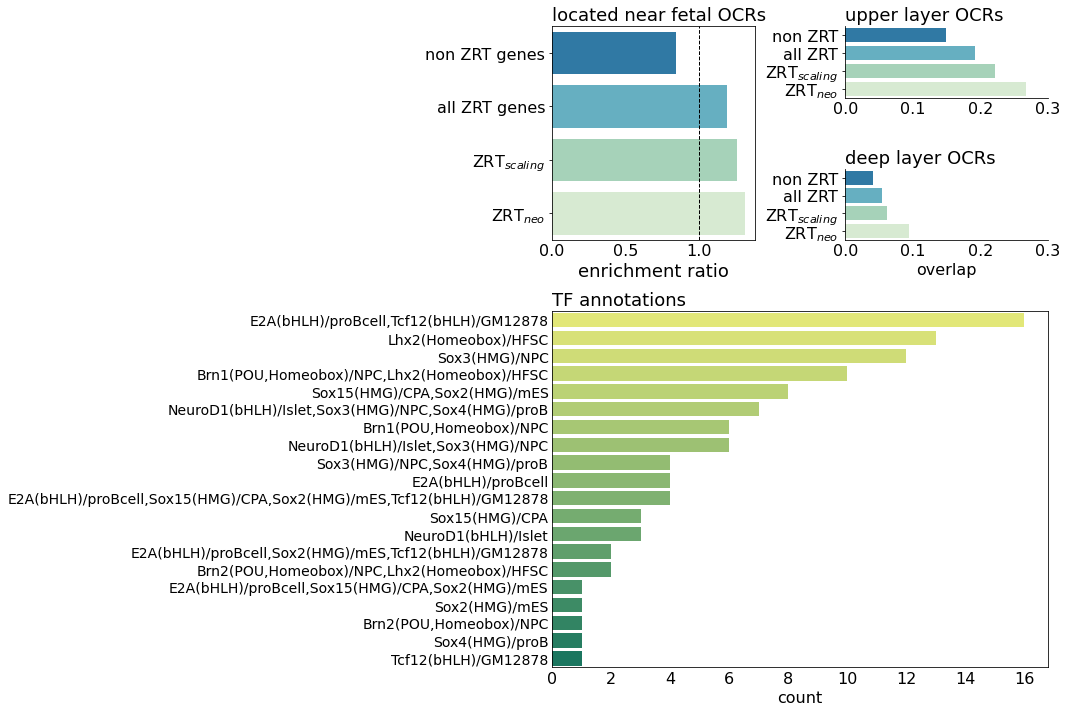

In [6]:
fig, ax = plt.subplot_mosaic('''
                    aabb
                    aacc
                    dddd
                    dddd
                    dddd
                    ''', figsize=(15,10))

sns.barplot(y='geneset', x='enrichment', data=enrichment_data, ax=ax['a'], palette='GnBu_r')
ax['a'].axvline(1,c='black', linestyle='--', lw=1)
ax['a'].set_yticks([0,1,2,3], ['non ZRT genes','all ZRT genes',r'ZRT$_{scaling}$',r'ZRT$_{neo}$'], fontsize=16)
ax['a'].set_ylabel('')
ax['a'].set_xlabel('enrichment ratio', fontsize=18)
ax['a'].tick_params('x', labelsize=16, length=0)
ax['a'].set_title('located near fetal OCRs',loc='left', fontsize=18)


sns.barplot(x='overlap', y='geneset', 
            data=upper_lower_enrichment_data[upper_lower_enrichment_data['ocrs']=='upper'],
            ax=ax['b'], palette='GnBu_r')
sns.barplot(x='overlap', y='geneset', 
            data=upper_lower_enrichment_data[upper_lower_enrichment_data['ocrs']=='lower'],
            ax=ax['c'], palette='GnBu_r')
ax['b'].set_title('upper layer OCRs', loc='left', fontsize=18)
ax['b'].set_yticks([0,1,2,3], ['non ZRT','all ZRT',r'ZRT$_{scaling}$',r'ZRT$_{neo}$'], fontsize=16)
ax['b'].set_ylabel('')
ax['b'].set_xlim(0,.3)
ax['b'].set_xlabel('')
ax['b'].tick_params('x', labelsize=16, length=0)


ax['c'].set_title('deep layer OCRs', loc='left', fontsize=18)
ax['c'].set_yticks([0,1,2,3], ['non ZRT','all ZRT',r'ZRT$_{scaling}$',r'ZRT$_{neo}$'], fontsize=16)
ax['c'].set_ylabel('')
ax['c'].set_xlim(0,.3)
ax['c'].set_xlabel('overlap', fontsize=16)
ax['c'].tick_params('x', labelsize=16, length=0)

sns.despine(ax=ax['b'])
sns.despine(ax=ax['c'])

sns.barplot(y='value', x='variable', data=tfs_count, ax=ax['d'], palette='summer_r')
ax['d'].set_title('TF annotations', loc='left', fontsize=18)
ax['d'].tick_params('y', labelsize=14, length=0)
ax['d'].set_ylabel('')
ax['d'].set_xlabel('count', fontsize=16)
ax['d'].tick_params('x', labelsize=16, length=0)

plt.tight_layout()
plt.savefig('RESULTS/ZRT-OCR-enrichment.png', dpi=300, transparent=False, facecolor='white')